# Restricted Boltzmann Machine (RBM)

RBMs are shallow neural nets that learn to reconstruct data by themselves in an unsupervised fashion.  It can automatically extract **meaningful** features from a given input. RBM takes the inputs and translates those into a set of binary values that represents them in the hidden layer. Then, these numbers can be translated back to reconstruct the inputs. Through several forward and backward passes, the RBM will be trained, and a trained RBM can reveal which features are the most important ones when detecting patterns.   

### Initialization

Load usefull modules:

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import fetch_openml
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
#import torch
#from torch.autograd import Variable

<a id="ref2"></a>
<h3>RBM layers</h3>

An RBM has two layers. The first layer of the RBM is called the **visible** (or input layer). The second layer is the **hidden** layer. For our toy sample, we'll use 2 nodes in the hidden layer.

<center><img src="https://ibm.box.com/shared/static/eu26opvcefgls6vnwuo29uwp0nudmokh.png" alt="RBM Model" style="width: 400px;"></center> (https://ibm.box.com/shared/static/eu26opvcefgls6vnwuo29uwp0nudmokh.png)

Each node in the first layer also has a <b>bias</b>. We will denote the bias as “v_bias” for the visible units. The <b>v_bias</b> is shared among all visible units.

Here we define the <b>bias</b> of second layer as well. We will denote the bias as “h_bias” for the hidden units. The <b>h_bias</b> is shared among all hidden units

In [3]:
v_bias = tf.placeholder("float", [7])
h_bias = tf.placeholder("float", [2])

We have to define weights among the input layer and hidden layer nodes. Let **W** be the Tensor of 7x2 (7 - number of visible neurons, 2 - number of hidden neurons) that represents weights between neurons. 

In [4]:
W = tf.constant(np.random.normal(loc=0.0, scale=1.0, size=(7, 2)).astype(np.float32))

Think RBM as a model that has been trained based on two set of images - A and B. Also, imagine that the RBM network has only two hidden nodes, for each one of the image types. In a training process, through many forward and backward passes, RBM adjust its weights to send a stronger signal to either the A node (0, 1) or the B node (1, 0) in the hidden layer, given the pixels of images. Now, given a A in hidden layer, which distribution of pixels should we expect? RBM can give you 2 things. First, it encodes your images in hidden layer. Second, it gives you the probability of observing a case, given some hidden values.

### How to inference?

RBM has two phases:
<ul>
    <li>Forward Pass</li>  
    <li>Backward Pass or Reconstruction</li>
</ul>

<b>Phase 1) Forward pass:</b>  Input one training sample (one image) <b>X</b> through all visible nodes, and pass it to all hidden nodes. Processing happens in each node in the hidden layer. This computation begins by making stochastic decisions about whether to transmit that input or not (i.e. to determine the state of each hidden layer). At the hidden layer's nodes, <b>X</b> is multiplied by a <b>$W_{ij}$</b> and added to <b>h_bias</b>. The result of those two operations is fed into the sigmoid function, which produces the node’s output, $p({h_j})$, where j is the unit number. 


$p({h_j})= \sigma(\sum_i w_{ij} x_i)$, where $\sigma()$ is the logistic function.


Now lets see what $p({h_j})$ represents. In fact, it is the probabilities of the hidden units. And, all values together are called <b>probability distribution</b>. That is, RBM uses inputs x to make predictions about hidden node activations. For example, imagine that the values of $h_p$ for the first training item is [0.51 0.84]. It tells you what is the conditional probability for each hidden neuron to be at Phase 1): 
<ul>
    <li>p($h_{1}$ = 1|V) = 0.51</li>
    <li>($h_{2}$ = 1|V) = 0.84</li>  
</ul>

As a result, for each row in the training set, <b>a vector/tensor</b> is generated, which in our case it is of size [1x2], and totally n vectors ($p({h})$=[nx2]). 

We then turn unit $h_j$ on with probability $p(h_{j}|V)$, and turn it off with probability $1 - p(h_{j}|V)$.

Therefore, the conditional probability of a configuration of h given v (for a training sample) is:

$$p(\mathbf{h} \mid \mathbf{v}) = \prod_{j=0}^H p(h_j \mid \mathbf{v})$$

Now, sample a hidden activation vector <b>h</b> from this probability distribution $p({h_j})$. That is, we sample the activation vector from the probability distribution of hidden layer values. 

Before we go further, let's look at a toy example for one case out of all input. Assume that we have a trained RBM, and a very simple input vector such as [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], lets see what would be the output of forward pass:

In [5]:
sess = tf.Session()
X = tf.constant([[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]])
v_state = X
print ("Input: ", sess.run(v_state))

h_bias = tf.constant([0.1, 0.1])
print ("hb: ", sess.run(h_bias))
print ("w: ", sess.run(W))

# Calculate the probabilities of turning the hidden units on:
h_prob = tf.nn.sigmoid(tf.matmul(v_state, W) + h_bias)  #probabilities of the hidden units
print ("p(h|v): ", sess.run(h_prob))

# Draw samples from the distribution:
h_state = tf.nn.relu(tf.sign(h_prob - tf.random_uniform(tf.shape(h_prob)))) #states
print ("h0 states:", sess.run(h_state))

Input:  [[1. 0. 0. 1. 0. 0. 0.]]
hb:  [0.1 0.1]
w:  [[ 1.0055009   1.2353511 ]
 [ 1.6183732   0.50333315]
 [-0.0615121   0.08113382]
 [-0.01624348 -0.4990354 ]
 [ 0.48692828  0.09463442]
 [ 1.3149623  -0.05218283]
 [-0.7157198   2.004222  ]]
p(h|v):  [[0.7482419 0.6976887]]
h0 states: [[1. 1.]]


<b>Phase 2) Backward Pass (Reconstruction):</b>
The RBM reconstructs data by making several forward and backward passes between the visible and hidden layers.

So, in the second phase (i.e. reconstruction phase), the samples from the hidden layer (i.e. h) play the role of input. That is, <b>h</b> becomes the input in the backward pass. The same weight matrix and visible layer biases are used to go through the sigmoid function. The produced output is a reconstruction which is an approximation of the original input.

In [6]:
vb = tf.constant([0.1, 0.2, 0.1, 0.1, 0.1, 0.2, 0.1])
print ("b: ", sess.run(vb))
v_prob = sess.run(tf.nn.sigmoid(tf.matmul(h_state, tf.transpose(W)) + vb))
print ("p(vi∣h): ", v_prob)
v_state = tf.nn.relu(tf.sign(v_prob - tf.random_uniform(tf.shape(v_prob))))
print ("v probability states: ", sess.run(v_state))

b:  [0.1 0.2 0.1 0.1 0.1 0.2 0.1]
p(vi∣h):  [[0.75128937 0.86037076 0.5096208  0.5209269  0.64266    0.8197955
  0.35075554]]
v probability states:  [[1. 1. 1. 1. 1. 1. 1.]]


RBM learns a probability distribution over the input, and then, after being trained, the RBM can generate new samples from the learned probability distribution. As you know, <b>probability distribution</b>, is a mathematical function that provides the probabilities of occurrence of different possible outcomes in an experiment.

The (conditional) probability distribution over the visible units v is given by

$p(\mathbf{v} \mid \mathbf{h}) = \prod_{i=0}^V p(v_i \mid \mathbf{h}),$


where,

$p(v_i \mid \mathbf{h}) = \sigma\left( a_i + \sum_{j=0}^H w_{ji} h_j \right)$


How similar X and V vectors are? Of course, the reconstructed values most likely will not look anything like the input vector because our network has not trained yet. Our objective is to train the model in such a way that the input vector and reconstructed vector to be same. Therefore, based on how different the input values look to the ones that we just reconstructed, the weights are adjusted. 

<hr>

## MINST

We will be using the MNIST dataset to practice the usage of RBMs. The following cell loads the MNIST dataset.


In [44]:
mnist = fetch_openml('mnist_784', version=1, return_X_y=True)

In [45]:
trX, _ = mnist
trX /= 255

In [46]:
trX.shape

(70000, 784)

Reduce the size of the datasample to execute faster the code, use for now only 1000 digits:

In [47]:
np.random.seed(42)
rndperm = np.random.permutation(trX.shape[0])
trX = trX[rndperm[:5000],:]

Let's biuld the RBM:

In [49]:
vb = tf.placeholder("float", [784])
hb = tf.placeholder("float", [50])

Let <b>W</b> be the Tensor of 784x50 (784 - number of visible neurons, 50 - number of hidden neurons) that represents weights between the neurons. 

In [50]:
W = tf.placeholder("float", [784, 50])

Lets define the visible layer:

In [51]:
v0_state = tf.placeholder("float", [None, 784])

Now, we can define hidden layer:

In [52]:
h0_prob = tf.nn.sigmoid(tf.matmul(v0_state, W) + hb)  #probabilities of the hidden units
h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random_uniform(tf.shape(h0_prob)))) #sample_h_given_X

Now, we define reconstruction part:

In [53]:
v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb) 
v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random_uniform(tf.shape(v1_prob)))) #sample_v_given_h

### What is objective function?
<b>Goal</b>: Maximize the likelihood of our data being drawn from that distribution

<b>Calculate error:</b>  
In each epoch, we compute the "error" as a sum of the squared difference between step 1 and step n,
e.g the error shows the difference between the data and its reconstruction.

<b>Note:</b> tf.reduce_mean computes the mean of elements across dimensions of a tensor.

In [54]:
err = tf.reduce_mean(tf.square(v0_state - v1_state))

<a id="ref4"></a>
<h3>How to train the model?</h3>
<b>Warning!!</b> The following part discuss how to train the model which needs some algebra background. Still, you can skip this part and run the next cells.

As mentioned, we want to give a high probability to the input data we train on. So, in order to train an RBM, we have to maximize the product of probabilities assigned to all rows v (images) in the training set V (a matrix, where each row of it is treated as a visible vector v):

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/d42e9f5aad5e1a62b11b119c9315236383c1864a">


Which is equivalent, maximizing the expected log probability of V:


<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/ba0ceed99dca5ff1d21e5ace23f5f2223f19efc0">


So, we have to update the weights wij  to increase p(v) for all v in our training data during training. So we have to calculate the derivative:


$$\frac{\partial \log p(\mathbf v)}{\partial w_{ij}}$$

This cannot be easily done by typical <b>gradient descent (SGD)</b>, so we can use another approach, which has 2 steps:
<ol>
    <li>Gibbs Sampling</li>
    <li>Contrastive Divergence</li>
</ol>    
    
<h3>Gibbs Sampling</h3>   
First, given an input vector v we are using p(h|v) for prediction of the hidden values h. 
<ul>
    <li>$p(h|v) = sigmoid(X \otimes W + hb)$</li>
    <li>h0 = sampleProb(h0)</li>
</ul>
    
Then, knowing the hidden values, we use p(v|h) for reconstructing of new input values v. 
<ul>
    <li>$p(v|h) = sigmoid(h0 \otimes transpose(W) + vb)$</li>
    <li>$v1 = sampleProb(v1)$  (Sample v given h)</li>
</ul>
        
This process is repeated k times. After k iterations we obtain an other input vector vk which was recreated from original input values v0 or X.

Reconstruction steps:
<ul>
    <li> Get one data point from data set, like <i>x</i>, and pass it through the net</li>
    <li>Pass 0: (x)  $\Rightarrow$ (h0) $\Rightarrow$  (v1)   (v1 is reconstruction of the first pass)</li>
    <li>Pass 1: (v1) $\Rightarrow$  (h1) $\Rightarrow$  (v2)   (v2 is reconstruction of the second pass)</li>
    <li>Pass 2: (v2) $\Rightarrow$  (h2) $\Rightarrow$  (v3)   (v3 is reconstruction of the third pass)</li>
    <li>Pass n: (vk) $\Rightarrow$  (hk+1) $\Rightarrow$  (vk+1)(vk is reconstruction of the nth pass)</li>
</ul>
        
<h4>What is sampling here (sampleProb)?</h4>

In forward pass: We randomly set the values of each hi to be 1 with probability $sigmoid(v \otimes W + hb)$.  
- To sample h given v means to sample from the conditional probability distribution P(h|v). It means that you are asking what are the probabilities of getting a specific set of values for the hidden neurons, given the values v for the visible neurons, and sampling from this probability distribution. 
In reconstruction: We randomly set the values of each vi to be 1 with probability $ sigmoid(h \otimes transpose(W) + vb)$.

<h3>contrastive divergence (CD-k)</h3>
The update of the weight matrix is done during the Contrastive Divergence step. 

Vectors v0 and vk are used to calculate the activation probabilities for hidden values h0 and hk. The difference between the outer products of those probabilities with input vectors v0 and vk results in the update matrix:


$\Delta W =v0 \otimes h0 - vk \otimes hk$ 

Contrastive Divergence is actually matrix of values that is computed and used to adjust values of the W matrix. Changing W incrementally leads to training of W values. Then on each step (epoch), W is updated to a new value W' through the equation below:

$W' = W + alpha * \Delta W$ 

 
<b>What is Alpha?</b>  
Here, alpha is some small step rate and is also known as the "learning rate".


Ok, lets assume that k=1, that is we just get one more step:

In [55]:
h1_prob = tf.nn.sigmoid(tf.matmul(v1_state, W) + hb)
h1_state = tf.nn.relu(tf.sign(h1_prob - tf.random_uniform(tf.shape(h1_prob)))) #sample_h_given_X

In [56]:
alpha = 0.01
W_Delta = tf.matmul(tf.transpose(v0_state), h0_prob) - tf.matmul(tf.transpose(v1_state), h1_prob)
update_w = W + alpha * W_Delta
update_vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
update_hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0)

Let's start a session and initialize the variables:

In [57]:
cur_w = np.zeros([784, 50], np.float32)
cur_vb = np.zeros([784], np.float32)
cur_hb = np.zeros([50], np.float32)
prv_w = np.zeros([784, 50], np.float32)
prv_vb = np.zeros([784], np.float32)
prv_hb = np.zeros([50], np.float32)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

Lets train the model

Epoch: 0 reconstruction error: 0.467830
Epoch: 1 reconstruction error: 0.237839
Epoch: 2 reconstruction error: 0.236963
Epoch: 3 reconstruction error: 0.219545
Epoch: 4 reconstruction error: 0.161946
Epoch: 5 reconstruction error: 0.142936
Epoch: 6 reconstruction error: 0.141275
Epoch: 7 reconstruction error: 0.119071
Epoch: 8 reconstruction error: 0.109999
Epoch: 9 reconstruction error: 0.107255


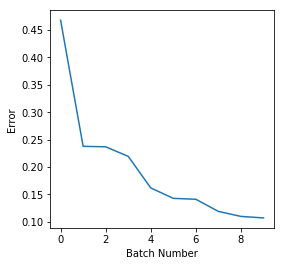

In [58]:
#Parameters
epochs = 10
batchsize = 200
weights = []
errors = []

for epoch in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={ v0_state: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0_state: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={ v0_state: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
        if start % 10000 == 0:
            errors.append(sess.run(err, feed_dict={v0_state: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
            weights.append(cur_w)
    print ('Epoch: %d' % epoch,'reconstruction error: %f' % errors[-1])
plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.show()

### Learned features

We can take each hidden unit and visualize the connections between that hidden unit and each element in the input vector. In our case, we have 50 hidden units. Lets visualize those.

Let's plot the current weights:

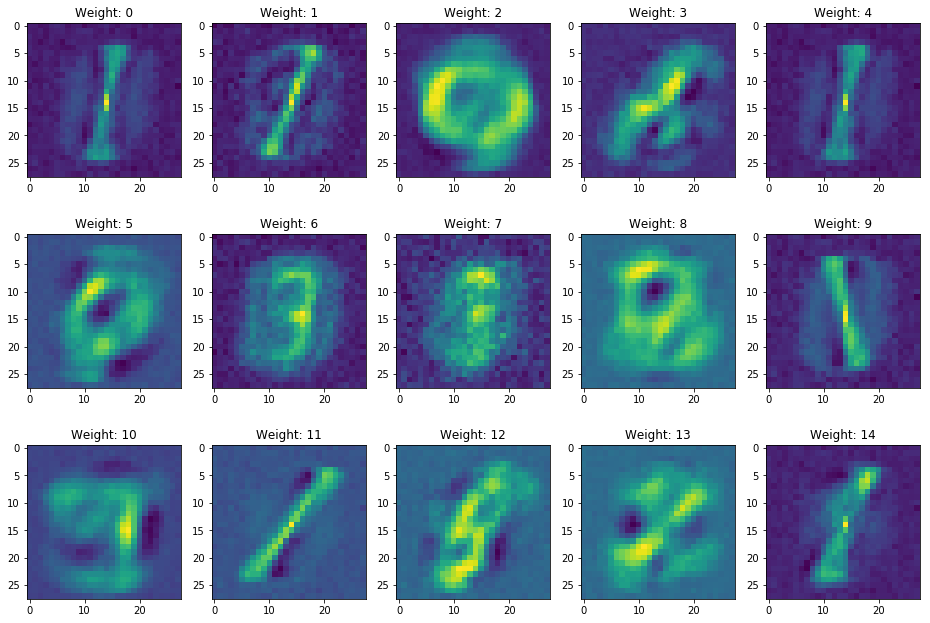

In [59]:
fig = plt.figure( figsize=(16,11) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="Weight: {}".format(str(i)) )
    ax.imshow(cur_w[:,i].reshape((28,28)).astype(float))
plt.show()

Each tile in the above visualization corresponds to a vector of connections between a hidden unit and visible layer's units. 

Let's look at one of the learned weights corresponding to one of hidden units for example. In this particular square, the gray color represents weight = 0, and the whiter it is, the more positive the weights are (closer to 1). Conversely, the darker pixels are, the more negative the weights. The positive pixels will increase the probability of activation in hidden units (after multiplying by input/visible pixels), and negative pixels will decrease the probability of a unit hidden to be 1 (activated). So, why is this important?  So we can see that this specific square (hidden unit) can detect a feature (e.g. a "/" shape) and if it exists in the input.

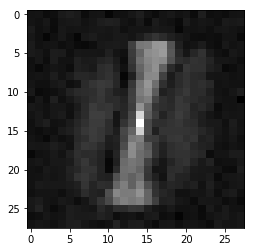

In [61]:
image = Image.fromarray(cur_w[:,4].reshape((28,28)).astype(float))
### Plot image
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')

Let's look at the reconstruction of an image now. Imagine that we have a destructed image of figure 3. Lets see if our trained network can fix it:

First we plot the image:

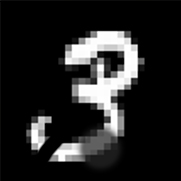

In [62]:
img = Image.open('images/destructed3.jpg')
img

In [63]:
# convert the image to a 1d numpy array
sample_case = np.array(img.convert('I').resize((28,28))).ravel().reshape((1, -1))/255.0

Feed the sample case into the network and reconstruct the output:

In [64]:
hh0_p = tf.nn.sigmoid(tf.matmul(v0_state, W) + hb)
#hh0_s = tf.nn.relu(tf.sign(hh0_p - tf.random_uniform(tf.shape(hh0_p)))) 
hh0_s = tf.round(hh0_p)
hh0_p_val,hh0_s_val  = sess.run((hh0_p, hh0_s), feed_dict={ v0_state: sample_case, W: prv_w, hb: prv_hb})
print("Probability nodes in hidden layer:" ,hh0_p_val)
print("activated nodes in hidden layer:" ,hh0_s_val)

# reconstruct
vv1_p = tf.nn.sigmoid(tf.matmul(hh0_s_val, tf.transpose(W)) + vb)
rec_prob = sess.run(vv1_p, feed_dict={ hh0_s: hh0_s_val, W: prv_w, vb: prv_vb})

Probability nodes in hidden layer: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9977034e-01 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 8.6492300e-04 0.0000000e+00
  9.9978608e-01 0.0000000e+00 7.9014897e-04 9.9999779e-01 1.7098784e-03
  0.0000000e+00 1.4901161e-07 0.0000000e+00 0.0000000e+00 0.0000000e+00
  9.9947059e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.0517578e-05
  0.0000000e+00 0.0000000e+00 0.0000000e+00 4.4703484e-07 2.9802322e-07
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.4901161e-07 3.3830702e-02 1.2931824e-03 1.8061963e-01
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.0000000e+00 4.5001507e-06 9.8244789e-05 1.2247229e-08]]
activated nodes in hidden layer: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0.]]


Here we plot the reconstructed image:

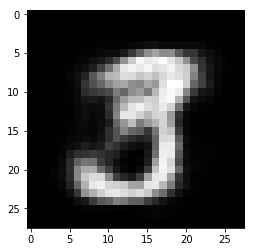

In [65]:
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(rec_prob.reshape((28,28)).astype(float))
imgplot.set_cmap('gray') 


<h1 align="center"><font size="5">RECOMMENDATION SYSTEM WITH A RESTRICTED BOLTZMANN MACHINE</font></h1>

Welcome to the <b>Recommendation System with a Restricted Boltzmann Machine</b> notebook. In this notebook, we study and go over the usage of a Restricted Boltzmann Machine (RBM) in a Collaborative Filtering based recommendation system. This system is an algorithm that recommends items by trying to find users that are similar to each other based on their item ratings. By the end of this notebook, you should have a deeper understanding of how Restricted Boltzmann Machines are applied, and how to build one using TensorFlow.

To start, we need to download the data we are going to use for our system. The datasets we are going to use were acquired by <a href="http://grouplens.org/datasets/movielens/">GroupLens</a> and contain movies, users and movie ratings by these users.

After downloading the data, we will extract the datasets to a directory that is easily accessible.

http://files.grouplens.org/datasets/movielens/ml-1m.zip


With the datasets in place, let's now import the necessary libraries. We will be using <a href="https://www.tensorflow.org/">Tensorflow</a> and <a href="http://www.numpy.org/">Numpy</a> together to model and initialize our Restricted Boltzmann Machine and <a href="http://pandas.pydata.org/pandas-docs/stable/">Pandas</a> to manipulate our datasets. To import these libraries, run the code cell below.

In [66]:
#Tensorflow library. Used to implement machine learning models
import tensorflow as tf
#Numpy contains helpful functions for efficient mathematical calculations
import numpy as np
#Dataframe manipulation library
import pandas as pd
#Graph plotting library
import matplotlib.pyplot as plt
%matplotlib inline

<a id="ref2"></a>
<h2>Loading in the Data</h2>

Let's begin by loading in our data with Pandas. The .dat files containing our data are similar to CSV files, but instead of using the ',' (comma) character to separate entries, it uses '::' (two colons) characters instead. To let Pandas know that it should separate data points at every '::', we have to specify the <code>sep='::'</code> parameter when calling the function.

Additionally, we also pass it the <code>header=None</code> parameter due to the fact that our files don't contain any headers.

Let's start with the movies.dat file and take a look at its structure:

In [67]:
#Loading in the movies dataset
movies_df = pd.read_csv('./data/movies.dat', sep='::', header=None, engine='python')
movies_df.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [68]:
#Loading in the ratings dataset
ratings_df = pd.read_csv('./data/ratings.dat', sep='::', header=None, engine='python')
ratings_df.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


So our <b>movies_df</b> variable contains a dataframe that stores a movie's unique ID number, title and genres, while our <b>ratings_df</b> variable stores a unique User ID number, a movie's ID that the user has watched, the user's rating to said movie and when the user rated that movie.

Let's now rename the columns in these dataframes so we can better convey their data more intuitively:

In [69]:
movies_df.columns = ['MovieID', 'Title', 'Genres']
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [70]:
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


<a id="ref3"></a>
<h2>The Restricted Boltzmann Machine model</h2>

<img src="https://ibm.box.com/shared/static/o049tx0dsllpbj3b546vuba25qqlzelq.png"  width="300">
<br>
The Restricted Boltzmann Machine model has two layers of neurons, one of which is what we call a visible input layer and the other is called a hidden layer. The hidden layer is used to learn features from the information fed through the input layer. For our model, the input is going to contain X neurons, where X is the amount of movies in our dataset. Each of these neurons will possess a normalized rating value varying from 0 to 1, where 0 meaning that a user has not watched that movie and the closer the value is to 1, the more the user likes the movie that neuron's representing. These normalized values, of course, will be extracted and normalized from the ratings dataset.

After passing in the input, we train the RBM on it and have the hidden layer learn its features. These features are what we use to reconstruct the input, which in our case, will predict the ratings for movies that user hasn't watched, which is exactly what we can use to recommend movies!

We will now begin to format our dataset to follow the model's expected input.

<h3>Formatting the Data</h3>

First let's see how many movies we have and see if the movie ID's correspond with that value:



In [71]:
len(movies_df)

3883

Now, we can start formatting the data into input for the RBM. We're going to store the normalized users ratings into as a matrix of user-rating called trX, and normalize the values.

In [72]:
user_rating_df = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating')
user_rating_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lets normalize it now:

In [73]:
norm_user_rating_df = user_rating_df.fillna(0) / 5.0
trX = norm_user_rating_df.values
trX[0:5]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<hr>
<a id="ref4"></a>
<h2>Setting the Model's Parameters</h2>
Next, let's start building our RBM with TensorFlow. We'll begin by first determining the number of neurons in the hidden layers and then creating placeholder variables for storing our visible layer biases, hidden layer biases and weights that connects the hidden layer with the visible layer. We will be arbitrarily setting the number of neurons in the hidden layers to 20. You can freely set this value to any number you want since each neuron in the hidden layer will end up learning a feature.

In [74]:
hiddenUnits = 20
visibleUnits =  len(user_rating_df.columns)
vb = tf.placeholder("float", [visibleUnits]) #Number of unique movies
hb = tf.placeholder("float", [hiddenUnits]) #Number of features we're going to learn
W = tf.placeholder("float", [visibleUnits, hiddenUnits])

We then move on to creating the visible and hidden layer units and setting their activation functions. In this case, we will be using the <code>tf.sigmoid</code> and <code>tf.relu</code> functions as nonlinear activations since it is commonly used in RBM's.

In [75]:
#Phase 1: Input Processing
v0 = tf.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))
#Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

In [76]:
#Learning rate
alpha = 1.0
#Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
#Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])
#Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

Instructions for updating:
Use tf.cast instead.


And set the error function, which in this case will be the Mean Absolute Error Function.

In [77]:
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

We also have to initialize our variables. Thankfully, NumPy has a handy ,code>zeros</code> function for this. We use it like so:

In [78]:
#Current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Current visible unit biases
cur_vb = np.zeros([visibleUnits], np.float32)
#Current hidden unit biases
cur_hb = np.zeros([hiddenUnits], np.float32)
#Previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Previous visible unit biases
prv_vb = np.zeros([visibleUnits], np.float32)
#Previous hidden unit biases
prv_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Now we train the RBM with 15 epochs with each epoch using 10 batches with size 100. After training, we print out a graph with the error by epoch.

0.059437085
0.050730474
0.04890734
0.047878947
0.04672462
0.046290286
0.04583218
0.045708045
0.045416366
0.0451759
0.04528775
0.045161072
0.044989757
0.044957884
0.044993393


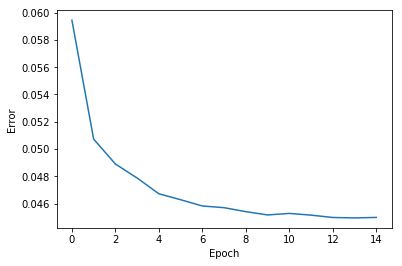

In [79]:
epochs = 15
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print (errors[-1])
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

<hr>
<a id="ref5"></a>
<h2>Recommendation</h2>

We can now predict movies that an arbitrarily selected user might like. This can be accomplished by feeding in the user's watched movie preferences into the RBM and then reconstructing the input. The values that the RBM gives us will attempt to estimate the user's preferences for movies that he hasn't watched based on the preferences of the users that the RBM was trained on.

Lets first select a <b>User ID</b> of our mock user:

In [62]:
mock_user_id = 215

In [63]:
#Selecting the input user
inputUser = trX[mock_user_id-1].reshape(1, -1)
inputUser[0:5]

array([[0.8, 0. , 0. , ..., 0. , 0. , 0. ]])

In [64]:
#Feeding in the user and reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})
print(rec)

[[0.3400905  0.10233128 0.03025326 ... 0.00344419 0.00187464 0.01176292]]


We can then list the 20 most recommended movies for our mock user by sorting it by their scores given by our model.

In [65]:
scored_movies_df_mock = movies_df[movies_df['MovieID'].isin(user_rating_df.columns)]
scored_movies_df_mock = scored_movies_df_mock.assign(RecommendationScore = rec[0])
scored_movies_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

,MovieID,Title,Genres,RecommendationScore
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,0.999431
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,0.974874
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.896121
585,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,0.890300
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,0.831270
1539,1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,0.825539
2559,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi,0.787785
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,0.745635
1220,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller,0.658858
1250,1270,Back to the Future (1985),Comedy|Sci-Fi,0.658015


So, how to recommend the movies that the user has not watched yet? 

Now, we can find all the movies that our mock user has watched before:



In [66]:
movies_df_mock = ratings_df[ratings_df['UserID'] == mock_user_id]
movies_df_mock.head()

,UserID,MovieID,Rating,Timestamp
31603,215,3793,5,977099259
31604,215,1,4,979174987
31605,215,1197,5,976899663
31606,215,2302,5,976899718
31607,215,2167,5,976899770


In the next cell, we merge all the movies that our mock users has watched with the predicted scores based on his historical data:

In [67]:
#Merging movies_df with ratings_df by MovieID
merged_df_mock = scored_movies_df_mock.merge(movies_df_mock, on='MovieID', how='outer')

lets sort it and take a look at the first 20 rows:

In [68]:
merged_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

,MovieID,Title,Genres,RecommendationScore,UserID,Rating,Timestamp
253,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,0.999431,215.0,5.0,976899190.0
1106,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,0.974874,NaN,NaN,NaN
2374,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.896121,NaN,NaN,NaN
575,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,0.890300,NaN,NaN,NaN
1120,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,0.831270,215.0,5.0,976899689.0
1449,1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,0.825539,NaN,NaN,NaN
2426,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi,0.787785,215.0,5.0,976908635.0
466,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,0.745635,215.0,5.0,976899784.0
1148,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller,0.658858,NaN,NaN,NaN
1178,1270,Back to the Future (1985),Comedy|Sci-Fi,0.658015,NaN,NaN,NaN


As you can see, there are some movies that user has not watched yet and has high score based on our model. So, we can recommend them to the user.

This is the end of the module. If you want, you can try to change the parameters in the code -- adding more units to the hidden layer, changing the loss functions or maybe something else to see if it changes anything. Does the model perform better? Does it take longer to compute?

Thank you for reading this notebook. Hopefully, you now have a little more understanding of the RBM model, its applications and how it works with TensorFlow.

<hr>

Notebook created by: <a href = "https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, Gabriel Garcez Barros Sousa